# **Sharpe vs Sortino**

## Comparação entre as duas métricas de retorno ajustado ao risco


### **Instalando bibliotecas e importação conteúdo**

In [1]:
!pip install quantstats -q
!pip install yfinance -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import quantstats as qs
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### **Fazendo a coleta de dados**

In [3]:
# Obtendo e gerando um DataFrame com dados de BTC-USD. Usaremos somente os dados de fechamento de 2018 até os dias atuais
df_btc = yf.download('BTC-USD', start = '2018-01-01')[['Close']]

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Visualização da base recém obtida
df_btc.head()

Close
Date                    
2018-01-01  13657.200195
2018-01-02  14982.099609
2018-01-03  15201.000000
2018-01-04  15599.200195
2018-01-05  17429.500000

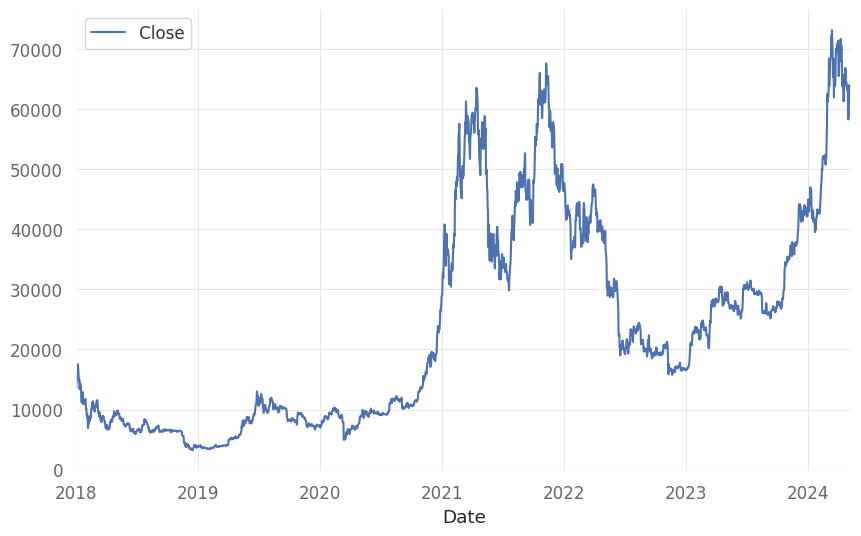

In [5]:
# Visualização gráfica da base recém obtida
df_btc.plot();

### **Análise das Métricas**

Dentre as várias funções da biblioteca quantstats, usaremos suas competências para o cálculo de Sharpe e Sortino:
* Faremos o cálculo em **janelas semestrais** (aprox. 126 dias):
    * **Rolling**: Faz rolagem dos dados para a janela de tempo desejada.
* Adotaremos **5%** como **Taxa Livre de Risco** semestral.


In [6]:
#Calculando o Sharpe em janelas
qs.stats.rolling_sharpe(df_btc['Close'], rf = 0.05)

Date
2018-01-01         NaN
2018-01-02         NaN
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
                ...   
2024-05-06    1.500353
2024-05-07    1.374151
2024-05-08    1.502861
2024-05-09    1.500427
2024-05-10    1.370683
Name: Close, Length: 2322, dtype: float64

In [7]:
# Transportando valores calculados para um dataframe
sharpe_qs = pd.Series(qs.stats.rolling_sharpe(df_btc['Close'], rf = 0.05).values)

In [8]:
# Fazendo o mesmo processo para o Sortino
sortino_qs = pd.Series(qs.stats.rolling_sortino(df_btc['Close'], rf = 0.05).values)

In [10]:
# Alterando índice dos novos dataframes, para que tenham o mesmo índice do dataframe base
sharpe_qs.index = df_btc.index
sortino_qs.index = df_btc.index

**Analisando a correlação entre os índices calculados**

Não vamos calcular a correlação, mas sim ver ela acontecendo no gráfico de dispersão

In [13]:
# Criando área de plotagem
fig_corr = go.Figure()

# Definindo os parâmetros da plotagem
fig_corr.add_trace({'type':'scatter',
                    'x': sharpe_qs,
                    'y': sortino_qs,
                    'mode': 'markers',
                    'line':{'color':'blue'}})

# Atualizando a área de plotagem de acordo com os parâmetros definidos acima e mais alguns detalhes visuais
fig_corr.update_layout(template='simple_white', paper_bgcolor="#f7f8fa",
                        margin=dict(l=70, r=20, t=20, b=70),
                        xaxis_title='<b>Sharpe', yaxis_title='<b>Sortino',
                        width=500, height=500)

Observamos uma correlação quase perfeita, existe linearidade na relação dos dois índices.

Faremos um teste de correlação para encontrar o valor de correlação dessas variáveis:
* r = valor de correlação;
* p = p-value baixo (<0.05) prova que existe forte correlação, ou seja, existe significância estatística na correlação.

In [12]:
# Teste de correlação de Pearson
corr, p = stats.pearsonr(sharpe_qs.dropna(), sortino_qs.dropna())
print('Correlação de Pearson, r=%.3f' %corr, 'p=%.3f' %p)

Correlação de Pearson, r=0.990 p=0.000


**Faremos agora a representação gráfica das informações encontrados**

In [16]:
# Criando área de plotagem, desta vez, com um 2o eixo y secundário
fig = make_subplots(specs = [[{"secondary_y": True}]])

# Primeiro eixo y - à esquerda e definindo seus parâmetros da plotagem
fig.add_trace(go.Scatter(x = sharpe_qs.index, y = sharpe_qs,
                         name = 'Sharpe', line = dict(color = 'blue', width = 2)),
              secondary_y = False)
# Primeiro eixo y - à esquerda e definindo seus parâmetros da plotagem
fig.add_trace(go.Scatter(x = sortino_qs.index, y = sortino_qs,
                         name = 'Sortino', line = dict(color = 'red', width = 2)),
              secondary_y = False)

# Segundo eixo y - à direita e definindo seus parâmetros da plotagem
fig.add_trace(go.Scatter(x = df_btc.index, y = np.log(df_btc['Close']),
                         name = 'Preço BTC-USD [log]', line = dict(color = 'black', width = 2)),
              secondary_y = True)

# Atualizando a área de plotagem de acordo com os parâmetros definidos acima e mais alguns detalhes visuais
fig.update_yaxes(title_text = 'Valores ajustados ao risco', secondary_y = False)
fig.update_yaxes(title_text = 'Preço BTC-USD [log]', secondary_y = True)
fig.update_layout(title='<b>Sharpe vs Sortino - Estudo Comparativo com Bitcoin', xaxis_title="<b>Data", legend_title="",
                  font=dict(family="Arial, Arial, Arial",size=15,color="black"), template = 'simple_white', paper_bgcolor="#f7f8fa",
                  margin=dict(l=75, r=20, t=70, b=70), legend=dict(orientation="h",yanchor="bottom",y=1,xanchor="right",x=0.4),
                  width=1000,height=500)

Fizemos a transformação logarítmica nos valores de preço do BTC, devido suas variações extremas:
*   np.log(df_btc['Close'])

Assim temos mais facilidade de interpretar e comparar seus movimentos, tanto com o Sharpe quanto Sortino.